In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from statsmodels.regression.linear_model import OLS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [4]:
# Relationship
true_intercept = 5
true_slope = 2

# Predictor
n_obs = 50
x_mean = 5
x_sd = 3
x = rng.normal(x_mean, x_sd, n_obs)
xarray = xr.DataArray(x, dims = ["plot_dim"])

# Target
true_line = true_intercept + true_slope * x
noise_mean = 0
noise_sd = 5
noise = rng.normal(noise_mean, noise_sd, n_obs)
y = true_line + noise

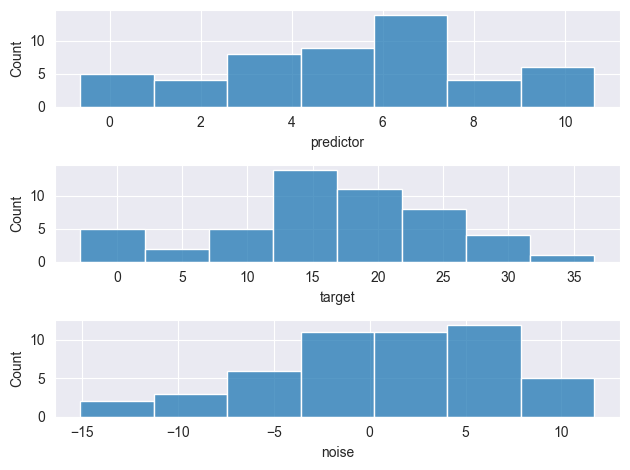

In [5]:
# Distributions of data
fig, ax = plt.subplots(3)

_ = sns.histplot(x, ax = ax[0])
_ = ax[0].set_xlabel("predictor")

_ = sns.histplot(y, ax = ax[1])
_ = ax[1].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[2])
_ = ax[2].set_xlabel("noise")

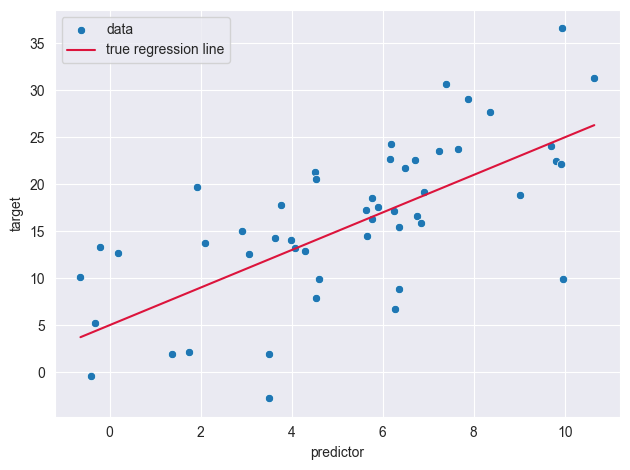

In [7]:
# True regression line
_ = sns.scatterplot(x = x, y = y, label = "data")
_ = sns.lineplot(x = x, y = true_line, label = "true regression line", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

## Frequentist OLS

In [8]:
constant = np.ones(n_obs)
exog = np.stack([x, constant]).transpose()

In [9]:
ols = OLS(endog = y, exog = exog)

In [10]:
ols_res = ols.fit()
ols_fitted = ols.predict(ols_res.params, exog)

In [11]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     38.43
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           1.24e-07
Time:                        16:26:52   Log-Likelihood:                -161.94
No. Observations:                  50   AIC:                             327.9
Df Residuals:                      48   BIC:                             331.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8870      0.304      6.199      0.000       1.275       2.499
const          6.2816      1.838      3.417      0.001       2.586       9.978
==============================================================================
Omnibus:                        2.977   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.424
Skew:                          -0.539   Prob(JB):                        0.298
Kurtosis:                       3.030   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

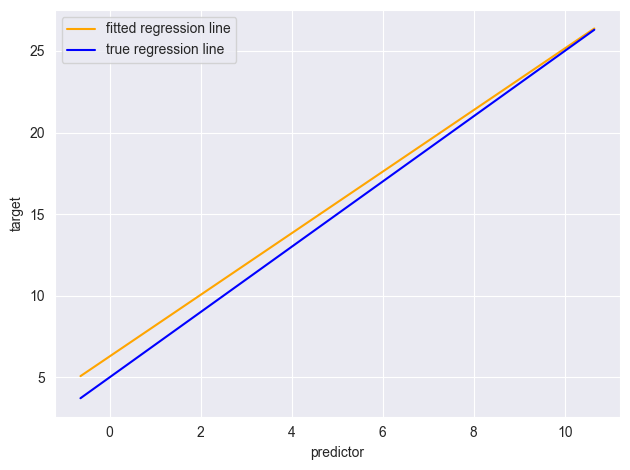

In [12]:
_ = sns.lineplot(
    x = x, 
    y = ols_fitted, 
    label = "fitted regression line", color = "orange")
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

## Flat prior


In [13]:
# Create model
flat_model = pm.Model()

In [14]:
# Define priors & likelihood
with flat_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 10)
    slope = pm.Normal("slope", mu = 0, sigma = 10)
    error = pm.Normal("error", mu = 0, sigma = 10)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [15]:
# Sample from the prior
with flat_model:
    flat_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


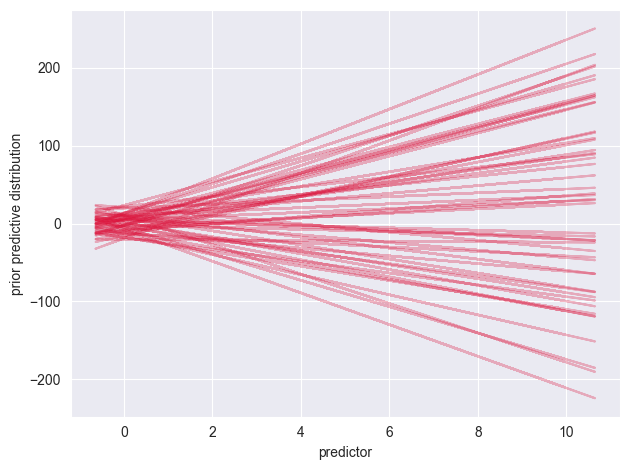

In [16]:
# Prior predictive check
y_flat_prior = (flat_prior.prior["intercept"] + flat_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_flat_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [17]:
# Draw posterior samples
with flat_model:
    flat_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [18]:
# Print posterior distribution summaries
az.summary(flat_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,6.1296,1.8214,2.7103,9.5294,0.0443,0.0323,1703.5486,1615.2401,1.0026
slope,1.9109,0.3000,1.3266,2.4412,0.0074,0.0052,1670.9749,1554.2774,1.0026
error,6.4483,0.6720,5.1919,7.6623,0.0152,0.0110,2054.4665,1728.1420,1.0012


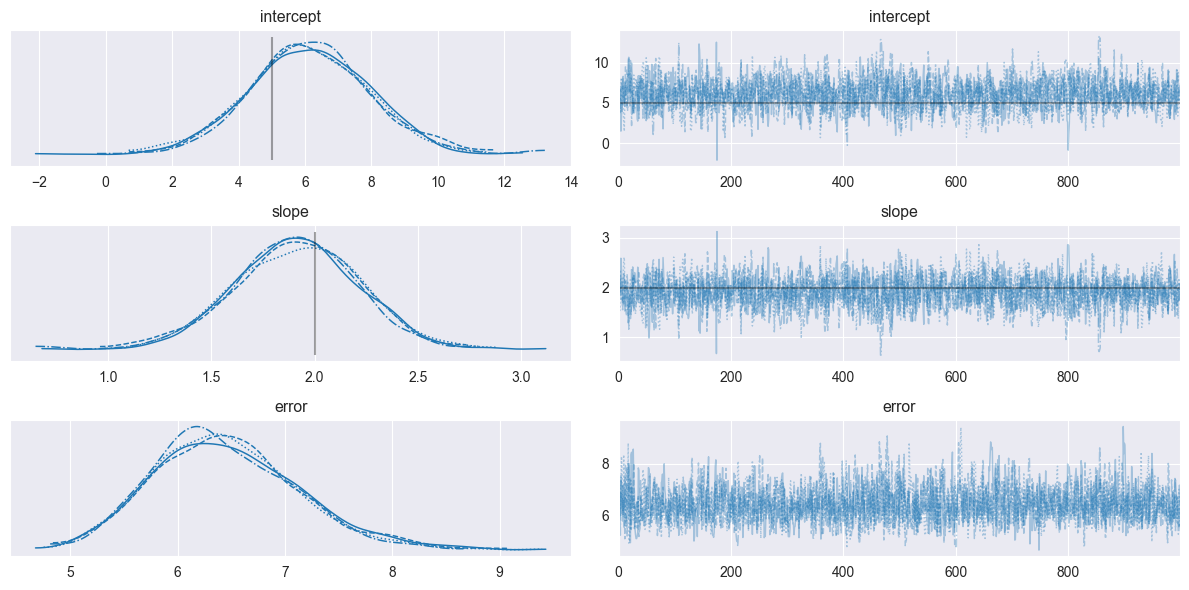

In [20]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    flat_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [21]:
# Simulate fitted regression lines
flat_posterior.posterior["fitted"] = flat_posterior.posterior["intercept"] + flat_posterior.posterior["slope"] * xarray

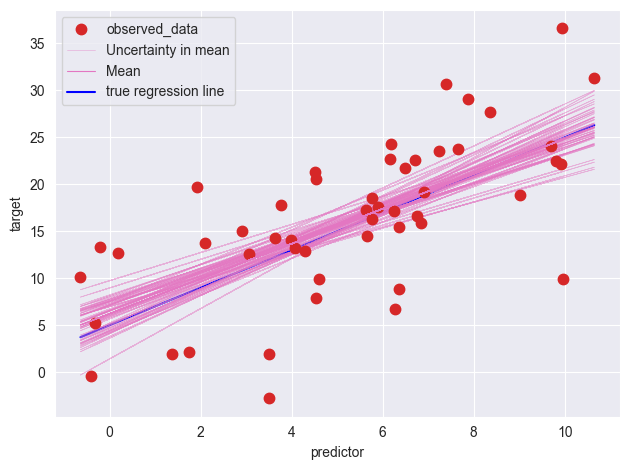

In [22]:
_ = az.plot_lm(
    idata = flat_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [23]:
# Sample from posterior
with flat_model:
    pm.sample_posterior_predictive(flat_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


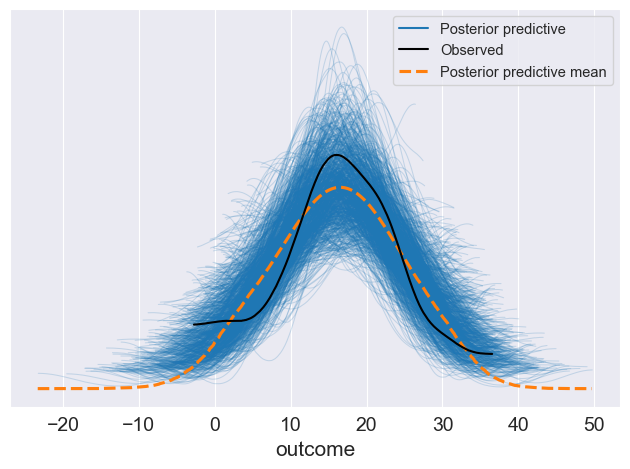

In [24]:
_ = az.plot_ppc(flat_posterior, num_pp_samples = 1000)

## Weakly informative prior

In [40]:
# Create model
weak_model = pm.Model()

In [41]:
# Define priors & likelihood
with weak_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 3.5, sigma = 2)
    slope = pm.Normal("slope", mu = 1.5, sigma = 1.5)
    error = pm.Normal("error", mu = 0, sigma = 7.5)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [42]:
# Sample from the prior
with weak_model:
    weak_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


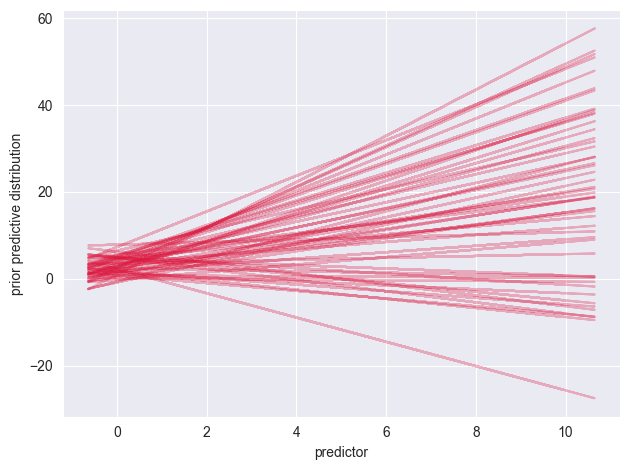

In [43]:
# Prior predictive check
y_weak_prior = (weak_prior.prior["intercept"] + weak_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_weak_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [44]:
# Draw posterior samples
with weak_model:
    weak_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [45]:
# Print posterior distribution summaries
az.summary(weak_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.0889,1.3316,2.7195,7.7171,0.0303,0.0215,1937.6945,2108.6006,1.0016
slope,2.0513,0.2412,1.5885,2.4899,0.0054,0.0038,2017.5263,2360.8603,1.0010
error,6.4216,0.6668,5.2615,7.6905,0.0144,0.0104,2362.8144,1835.7536,1.0011


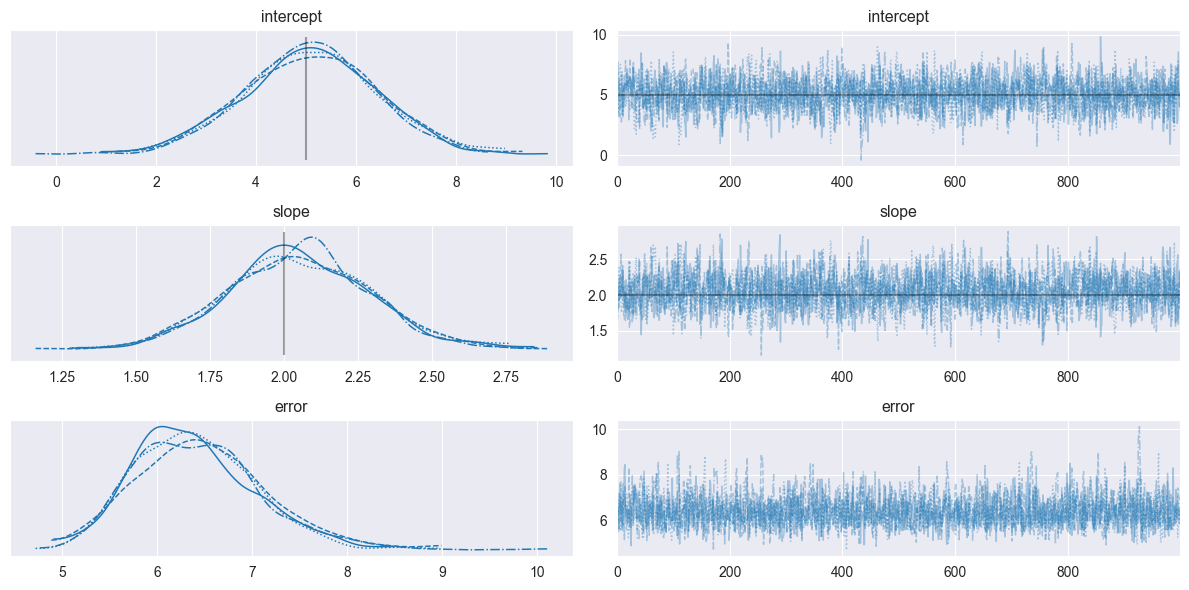

In [46]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    weak_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [47]:
# Simulate fitted regression lines
weak_posterior.posterior["fitted"] = weak_posterior.posterior["intercept"] + weak_posterior.posterior["slope"] * xarray

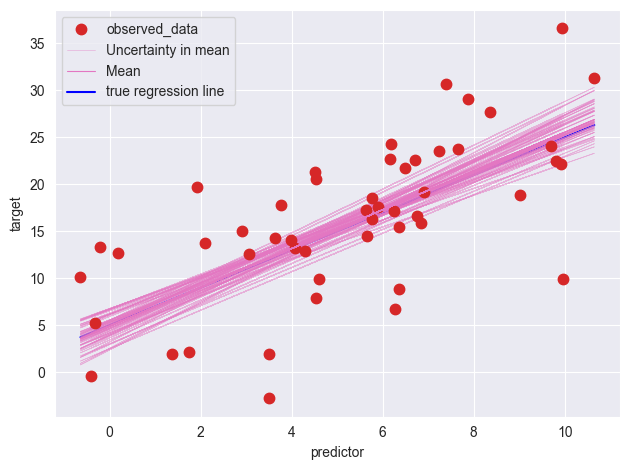

In [48]:
_ = az.plot_lm(
    idata = weak_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [49]:
# Sample from posterior
with weak_model:
    pm.sample_posterior_predictive(weak_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


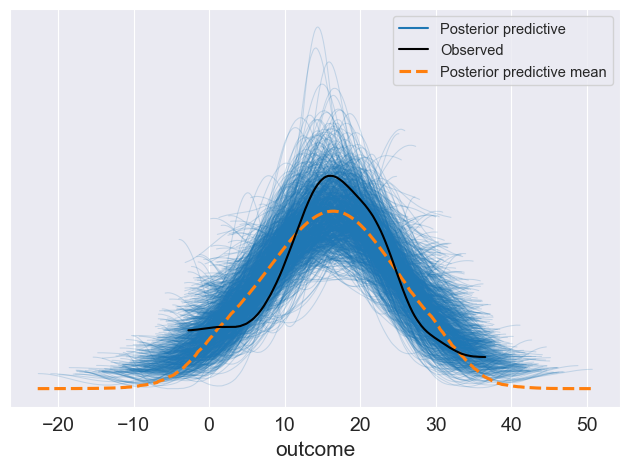

In [50]:
_ = az.plot_ppc(weak_posterior, num_pp_samples = 1000)

## Strong informative prior

In [54]:
# Create model
strong_model = pm.Model()

In [55]:
# Define priors & likelihood
with strong_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 4.5, sigma = 1)
    slope = pm.Normal("slope", mu = 1.5, sigma = 0.5)
    error = pm.Normal("error", mu = 0, sigma = 5)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [56]:
# Sample from the prior
with strong_model:
    strong_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


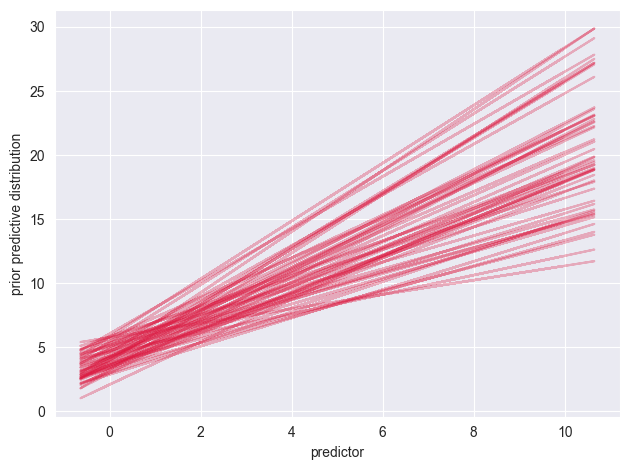

In [57]:
# Prior predictive check
y_strong_prior = (strong_prior.prior["intercept"] + strong_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_strong_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [58]:
# Draw posterior samples
with strong_model:
    strong_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [59]:
# Print posterior distribution summaries
az.summary(strong_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.1196,0.8416,3.5056,6.6747,0.0175,0.0124,2320.4803,2611.2954,1.0011
slope,2.0103,0.1811,1.7027,2.3867,0.0037,0.0027,2333.8429,2796.4813,1.0021
error,6.3339,0.6413,5.1920,7.5111,0.0118,0.0085,3157.3946,2532.8037,1.0008


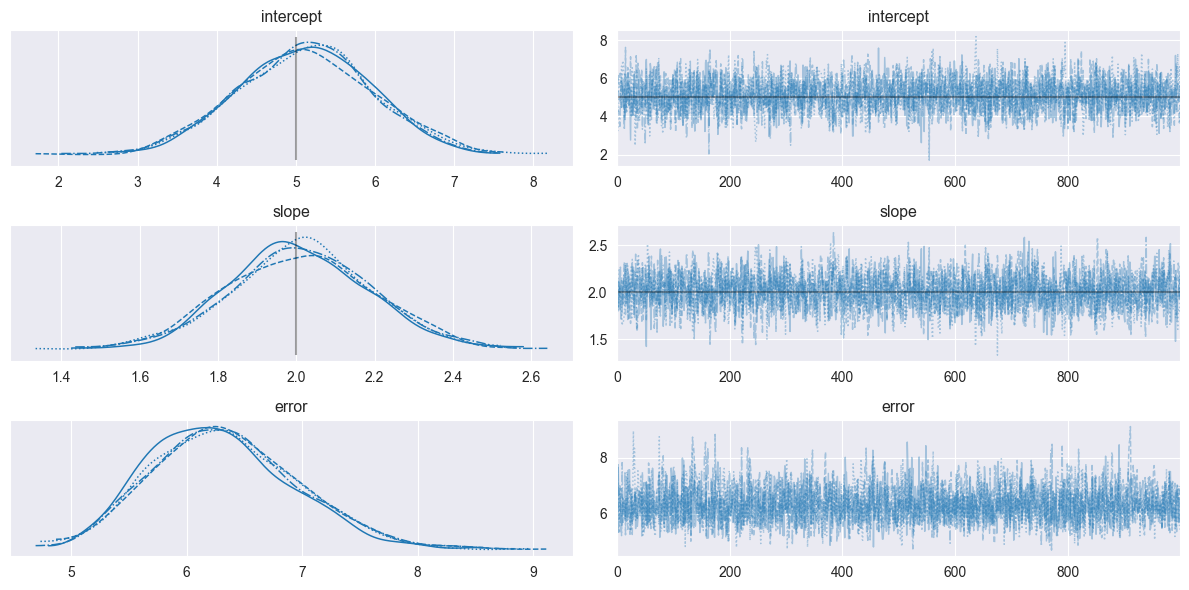

In [60]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    strong_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [61]:
# Simulate fitted regression lines
strong_posterior.posterior["fitted"] = strong_posterior.posterior["intercept"] + strong_posterior.posterior["slope"] * xarray

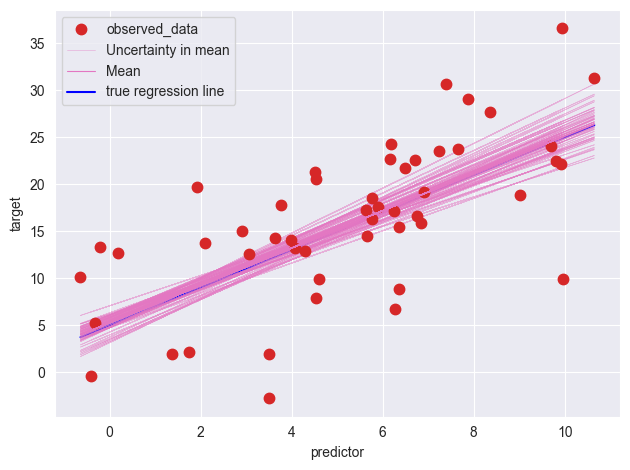

In [62]:
_ = az.plot_lm(
    idata = strong_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [63]:
# Sample from posterior
with strong_model:
    pm.sample_posterior_predictive(strong_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


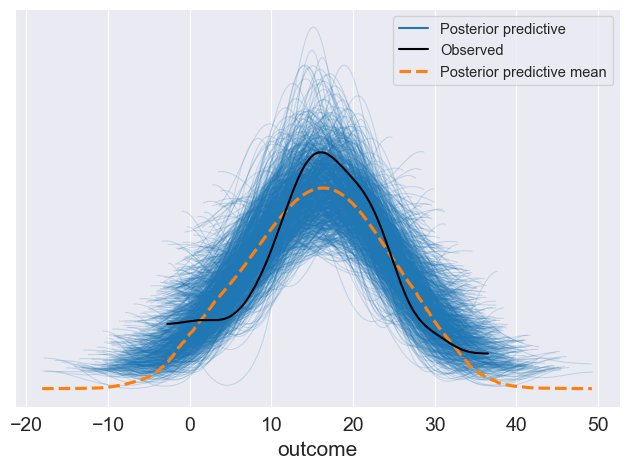

In [64]:
_ = az.plot_ppc(strong_posterior, num_pp_samples = 1000)

## Strong wrong prior

In [65]:
# Create model
wrong_model = pm.Model()

In [66]:
# Define priors & likelihood
with wrong_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 1)
    slope = pm.Normal("slope", mu = 5, sigma = 0.5)
    error = pm.Normal("error", mu = 0, sigma = 1)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [67]:
# Sample from the prior
with wrong_model:
    wrong_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


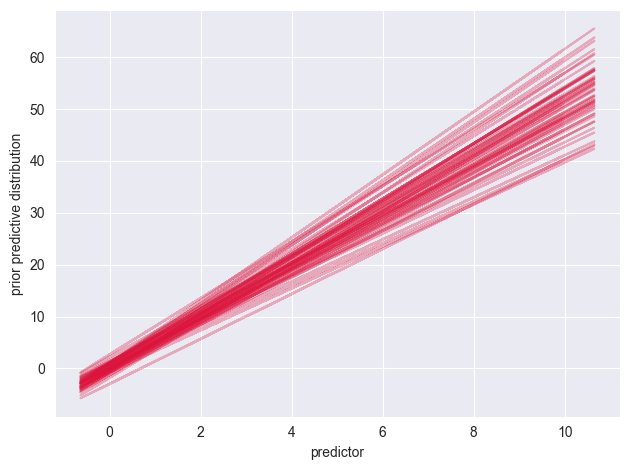

In [68]:
# Prior predictive check
y_wrong_prior = (wrong_prior.prior["intercept"] + wrong_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_wrong_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [69]:
# Draw posterior samples
with wrong_model:
    wrong_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [70]:
# Print posterior distribution summaries
az.summary(wrong_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.8461,0.8415,-0.6918,2.5071,0.0195,0.0138,1854.9266,2619.3352,1.0016
slope,2.8181,0.1724,2.4996,3.1327,0.0039,0.0028,1966.5934,2218.4650,1.0011
error,5.4825,0.3847,4.7704,6.1857,0.0086,0.0061,2020.5648,2376.4285,1.0019


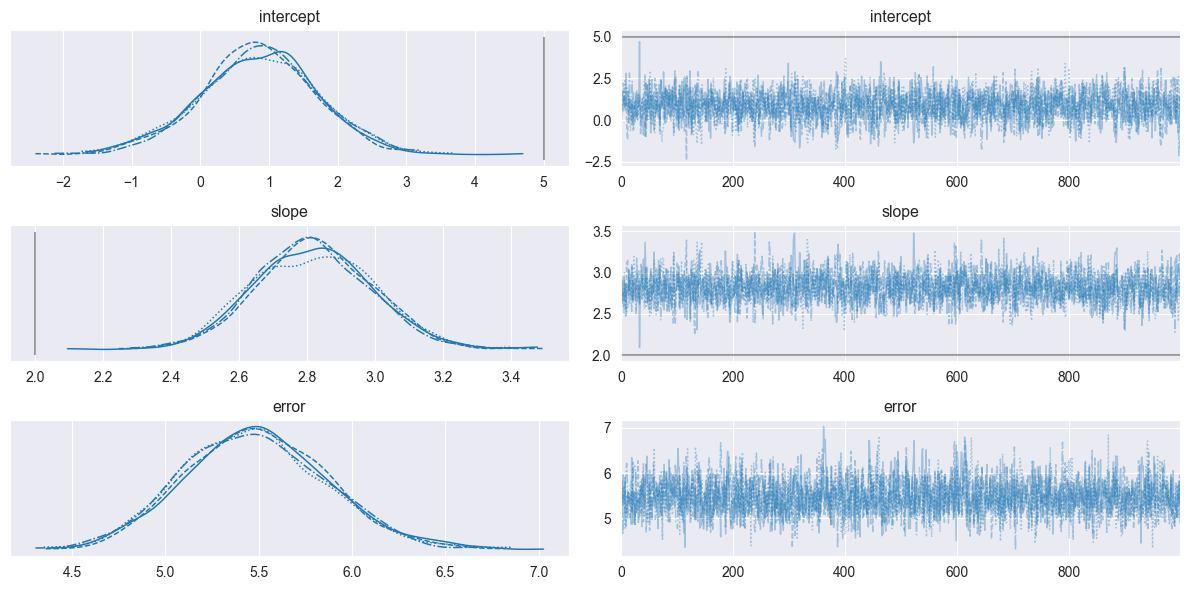

In [71]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    wrong_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [72]:
# Simulate fitted regression lines
wrong_posterior.posterior["fitted"] = wrong_posterior.posterior["intercept"] + wrong_posterior.posterior["slope"] * xarray

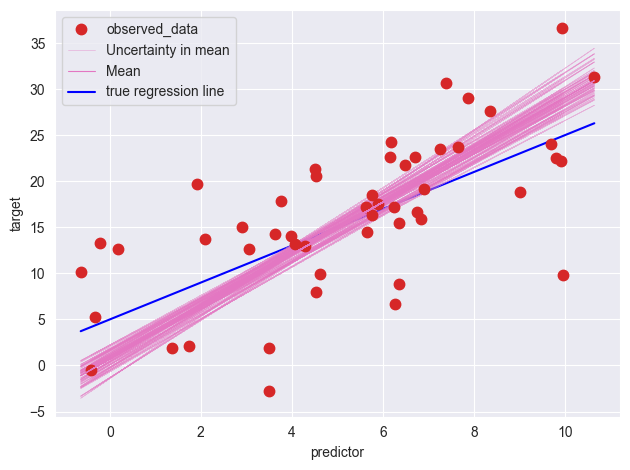

In [73]:
_ = az.plot_lm(
    idata = wrong_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [74]:
# Sample from posterior
with wrong_model:
    pm.sample_posterior_predictive(wrong_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


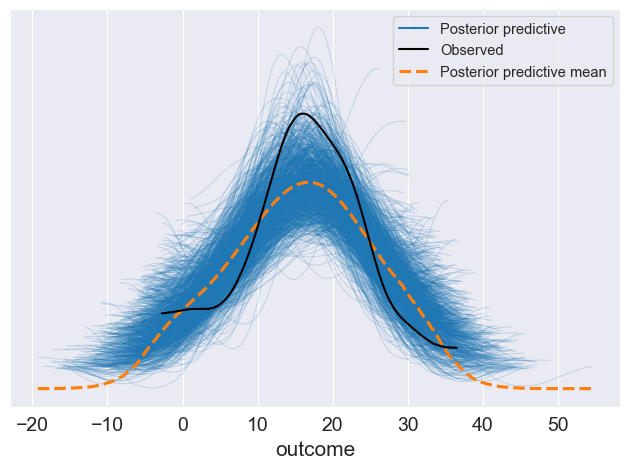

In [75]:
_ = az.plot_ppc(wrong_posterior, num_pp_samples = 1000)